Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - loss: 0.0944 - val_loss: 0.0102
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 0.0090 - val_loss: 0.0045
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - loss: 0.0046 - val_loss: 0.0025
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.0011 - val_loss: 8.0961e-04
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 0.0011 - val_loss: 8.3799e-04
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - loss: 9.3693e-04 - val_loss: 6.1963e-04
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 7.7900e-04 - v

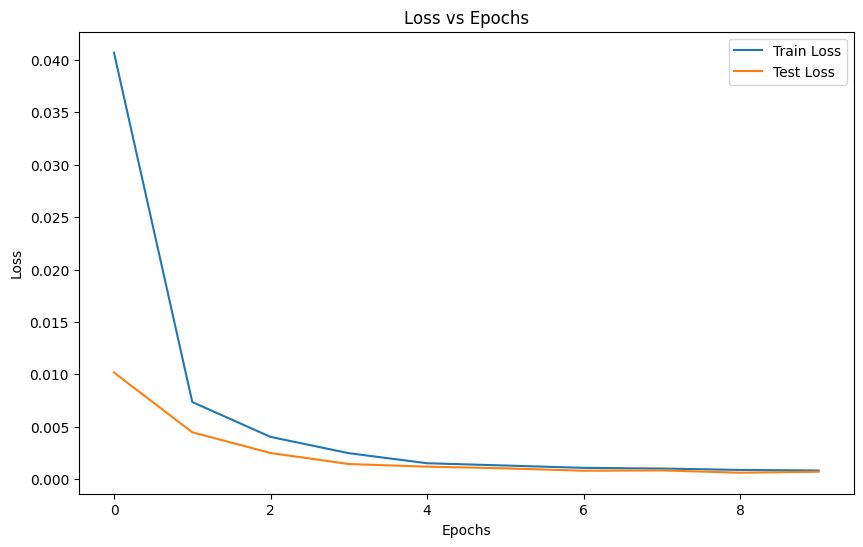

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


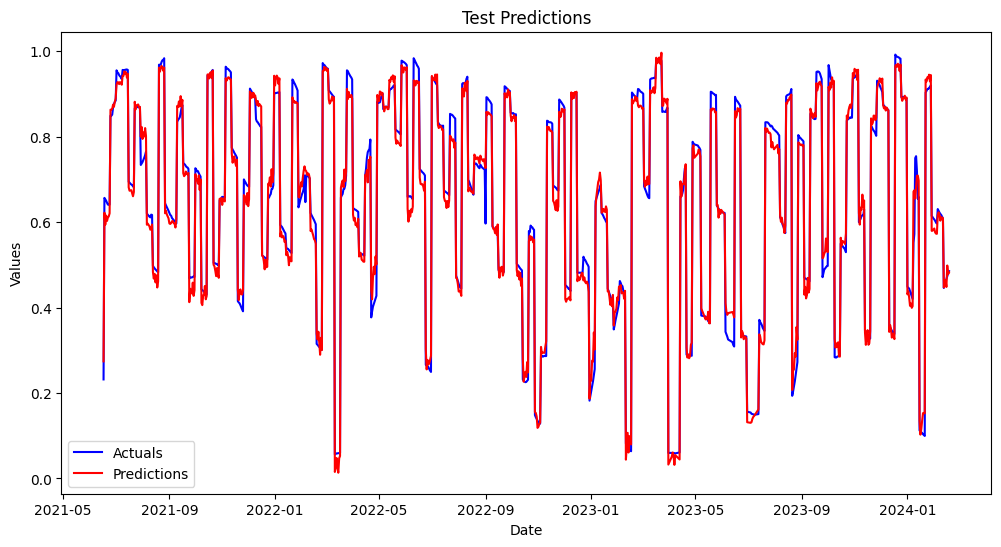

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[0.9024504  0.8987765  0.8996481  0.90203756 0.8998524  0.9010407
 0.9016425 ]


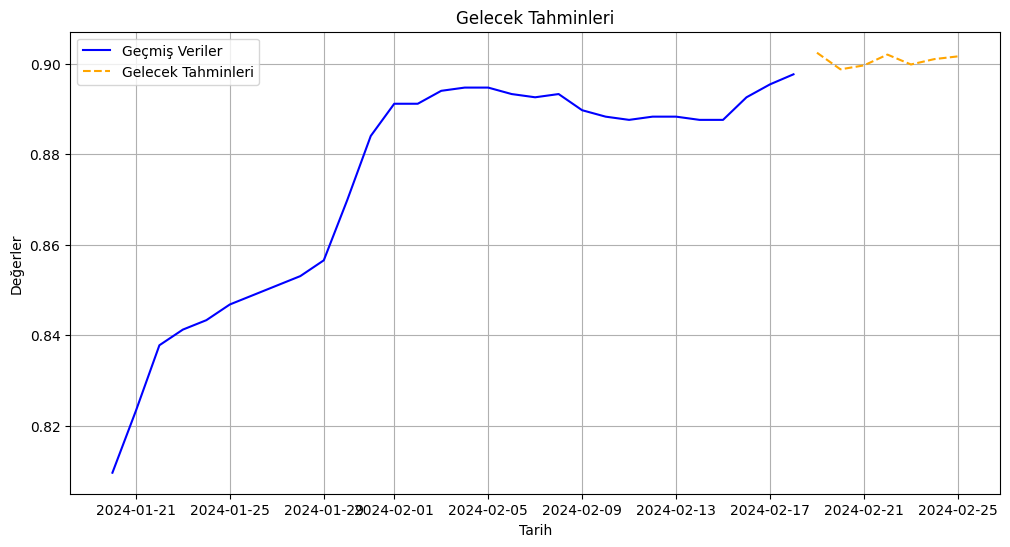

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, Add, MultiHeadAttention, LSTM, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from math import sqrt
from google.colab import drive
import random
# Rastgelelik kontrolü
np.random.seed(42)
tf.random.set_seed(42)
drive.mount('/content/drive')
# Veri setini yükle
df = pd.read_json("/content/drive/MyDrive/Processed_Baraj_Data_Fixed_Deneme.json")

df['Tarih'] = pd.to_datetime(df['Tarih'])
df['Yil'] = df['Tarih'].dt.year
df['Ay'] = df['Tarih'].dt.month
df['Gun'] = df['Tarih'].dt.day
original_dates = df['Tarih']
df = df.drop(columns=['Tarih'])

df['mevsim'] = df['Ay'].apply(lambda x: 1 if x in [12, 1, 2] else (2 if x in [3, 4, 5] else (3 if x in [6, 7, 8] else 4)))

rain_columns = [col for col in df.columns if '_Yagis' in col]
df['toplam_yağış'] = df[rain_columns].sum(axis=1)

df['kümülatif_yağış_7gün'] = df['toplam_yağış'].rolling(window=7).sum()
df['yağış_lag_1'] = df['toplam_yağış'].shift(1)
df['yağış_lag_2'] = df['toplam_yağış'].shift(2)
df.fillna(0, inplace=True)

target_column = "Omerli_Doluluk"
input_features = df.drop(columns=[target_column]).values
target_values = df[target_column].values

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(input_features)
scaled_target = scaler.fit_transform(target_values.reshape(-1, 1))

def create_sequences(data, target, input_window, output_window):
    X, y = [], []
    for i in range(len(data) - input_window - output_window):
        X.append(data[i:i+input_window])
        y.append(target[i+input_window:i+input_window+output_window])
    return np.array(X), np.array(y)

input_window = 30
output_window = 7
X, y = create_sequences(scaled_features, scaled_target, input_window, output_window)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def gated_residual_network(x, units, dropout_rate=0.1):
    dense = Dense(units, activation='relu')(x)
    dropout = Dropout(dropout_rate)(dense)
    add = Add()([x, dropout])
    norm = LayerNormalization()(add)
    return norm

def build_tft_model(input_dim, output_dim, embed_dim=64, num_heads=4, dropout_rate=0.05):
    inputs = Input(shape=(input_window, input_dim))
    x = Dense(embed_dim, activation='relu')(inputs)
    x = LayerNormalization()(x)
    x = Dropout(dropout_rate)(x)

    attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    x = Add()([x, attn_out])
    x = LayerNormalization()(x)

    x = gated_residual_network(x, embed_dim)

    lstm_out = LSTM(embed_dim, return_sequences=True)(x)
    lstm_out = LSTM(embed_dim)(lstm_out)

    outputs = Dense(output_dim, activation='relu')(lstm_out)
    model = Model(inputs, outputs)
    return model

input_dim = X_train.shape[2]
output_dim = y_train.shape[1]
model = build_tft_model(input_dim, output_dim)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

start_time = time.time()
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
train_time = time.time() - start_time

start_time = time.time()
predictions = model.predict(X_test)
inference_time = time.time() - start_time
actuals = y_test.flatten()
predictions = predictions.flatten()
print("\n=== Model Training and Inference Times ===")
print(f"Training Time   = {train_time:.2f} seconds")
print(f"Inference Time  = {inference_time:.2f} seconds")
actuals_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
predictions_real = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()


mse = mean_squared_error(actuals_real, predictions_real)
rmse = sqrt(mse)
mae = mean_absolute_error(actuals_real, predictions_real)
mape = mean_absolute_percentage_error(actuals_real, predictions_real)
r2 = r2_score(actuals_real, predictions_real)


print("\n=== Test Results ===")
print(f"MSE   = {mse:.4f}")
print(f"RMSE  = {rmse:.4f}")
print(f"MAE   = {mae:.4f}")
print(f"MAPE  = {mape:.4f}")
print(f"R²    = {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.show()

predictions = model.predict(X_test).flatten()
actuals = y_test.flatten()
relevant_dates = original_dates[-len(y_test):]

min_len = min(len(relevant_dates), len(actuals), len(predictions))
relevant_dates = relevant_dates[-min_len:]
actuals = actuals[-min_len:]
predictions = predictions[-min_len:]

plt.figure(figsize=(12, 6))
plt.plot(relevant_dates, actuals, label="Actuals", color="blue")
plt.plot(relevant_dates, predictions, label="Predictions", color="red")
plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Test Predictions")
plt.legend()
plt.show()

future_dates = pd.date_range(original_dates.iloc[-1], periods=output_window + 1, freq='D')[1:]
future_predictions = []
input_sequence = scaled_features[-input_window:].reshape(1, input_window, -1)

for _ in range(output_window):
    future_pred = model.predict(input_sequence)
    future_predictions.append(future_pred.flatten()[0])
    input_sequence[0, -1, 0] = future_pred.flatten()[0]
    input_sequence = np.roll(input_sequence, shift=-1, axis=1)

future_predictions_actual = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

print(future_predictions_actual)

plt.figure(figsize=(12, 6))
plt.plot(original_dates[-30:], scaler.inverse_transform(target_values[-30:].reshape(-1, 1)), label="Geçmiş Veriler", color="blue")
plt.plot(future_dates, future_predictions_actual, label="Gelecek Tahminleri", linestyle="--", color="orange")
plt.xlabel("Tarih")
plt.ylabel("Değerler")
plt.title("Gelecek Tahminleri")
plt.legend()
plt.grid()
plt.show()